<a href="https://colab.research.google.com/github/anagh07/stock_price_predictor/blob/colab/lstm_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
import os
import pyspark.sql.functions as f
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras import models, layers
import sklearn.metrics as metrics
from matplotlib import pyplot as plt

     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 198 kB 61.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=6fb820bc3372306dc8ec23d4b23d01c3e0ffa069d355b790b945c834e2dc0407
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/stocks_kaggle_dataset1/

/content/drive/MyDrive/stocks_kaggle_dataset1


In [6]:
%cd full_history/

/content/drive/MyDrive/stocks_kaggle_dataset1/full_history


# **Data Preprocessing:**

In [7]:
spark = SparkSession.builder.getOrCreate()

In [8]:
# list of companies we analyze
companies = ['NVDA', 'GOOG', 'AAPL', 'AMZN', 'FB', 'MSFT', 'TXN',
             'AVGO', 'CSCO', 'ADBE', 'ORCL', 'CRM', 'QCOM', 'NFLX', 
             'BKNG', 'EXPE', 'INTC', 'INTU', 'FTNT', 'IBM', 'EBAY', 
             'HP', 'ADSK', 'EA', 'AMD']
# ask user to enter comany name:
company_name = input("Please select one of the following companies: \n"
                     + "'NVDA', 'GOOG', 'AAPL', 'AMZN', 'FB', 'MSFT', 'TXN','AVGO',"
                     + " 'CSCO', 'ADBE', 'ORCL', 'CRM', 'QCOM', 'NFLX','BKNG', 'EXPE',"
                     + " 'INTC', 'INTU', 'FTNT', 'IBM', 'EBAY','HP', 'ADSK', 'EA', 'AMD'")
company_name = company_name.upper()
if company_name not in companies:
  print("invalid company name!")
else:
  filename = '/content/drive/MyDrive/stocks_kaggle_dataset1/full_history/' + company_name + '.csv'
  df = spark.read.csv(filename, header=True, mode="DROPMALFORMED")
  df.show()


Please select one of the following companies: 
'NVDA', 'GOOG', 'AAPL', 'AMZN', 'FB', 'MSFT', 'TXN','AVGO', 'CSCO', 'ADBE', 'ORCL', 'CRM', 'QCOM', 'NFLX','BKNG', 'EXPE', 'INTC', 'INTU', 'FTNT', 'IBM', 'EBAY','HP', 'ADSK', 'EA', 'AMD'goog
+----------+-------+------------------+------------------+------------------+------------------+------------------+
|      date| volume|              open|             close|              high|               low|          adjclose|
+----------+-------+------------------+------------------+------------------+------------------+------------------+
|2018-11-02|1838200|  1073.72998046875|   1057.7900390625|1082.9749755859375|1054.6099853515625|   1057.7900390625|
|2018-11-01|1482000| 1075.800048828125|            1070.0|1083.9749755859375|   1062.4599609375|            1070.0|
|2018-10-31|2529800|  1059.81005859375|  1076.77001953125|  1091.93994140625|            1057.0|  1076.77001953125|
|2018-10-30|3212700|1008.4600219726562|   1036.2099609375| 1037.489

In [9]:
#converting date from string to date format
df = df.withColumn('date', f.to_date('Date'))
# breakdown the date into year-month-day
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, f.split('date', '-')[index])

df.show(n=10)

+----------+-------+------------------+------------------+------------------+------------------+------------------+----+-----+---+
|      date| volume|              open|             close|              high|               low|          adjclose|year|month|day|
+----------+-------+------------------+------------------+------------------+------------------+------------------+----+-----+---+
|2018-11-02|1838200|  1073.72998046875|   1057.7900390625|1082.9749755859375|1054.6099853515625|   1057.7900390625|2018|   11| 02|
|2018-11-01|1482000| 1075.800048828125|            1070.0|1083.9749755859375|   1062.4599609375|            1070.0|2018|   11| 01|
|2018-10-31|2529800|  1059.81005859375|  1076.77001953125|  1091.93994140625|            1057.0|  1076.77001953125|2018|   10| 31|
|2018-10-30|3212700|1008.4600219726562|   1036.2099609375| 1037.489990234375|           1000.75|   1036.2099609375|2018|   10| 30|
|2018-10-29|3880700| 1082.469970703125|1020.0800170898438|   1097.0400390625| 995.8

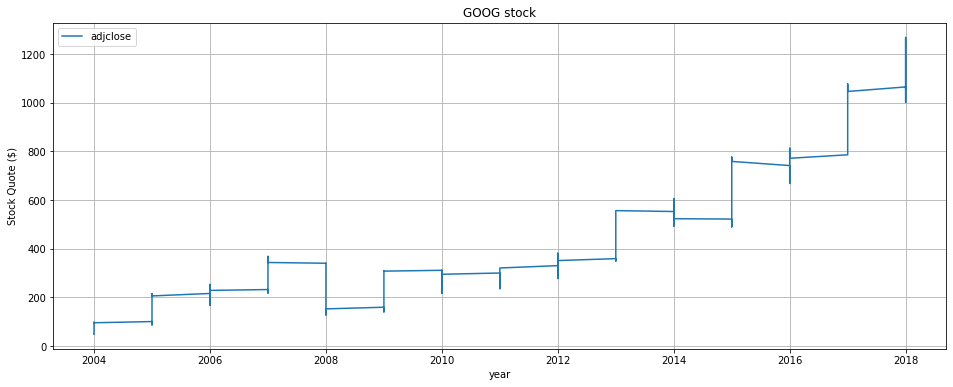

In [10]:
#plot the adjacent close price for the selected stock over the time
%matplotlib inline
df_plot = df.select('year', 'adjclose').toPandas()
df_plot.dtypes
df_plot['year']=df_plot['year'].astype(float)
df_plot['adjclose']=df_plot['adjclose'].astype(float)
df_plot.set_index('year', inplace=True)
df_plot.plot(figsize=(16, 6), grid=True)
plt.title(company_name + ' stock')
plt.ylabel('Stock Quote ($)')
plt.show()

In [11]:
#checking for null values:
df.toPandas().shape

(3579, 10)

In [12]:
df.dropna().count()

3579

In [13]:
df.select('Open', 'High', 'Low', 'Close', 'adjclose').describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|              Open|              High|               Low|             Close|          adjclose|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              3579|              3579|              3579|              3579|              3579|
|   mean| 434.0883126665208| 437.9575166619667| 429.8905840956589|433.98656103150677|433.98656103150677|
| stddev|288.00679606605934| 290.1336694777615|285.80207843518883| 288.0562219370731| 288.0562219370731|
|    min|100.04927825927734|100.14862823486328|100.64540100097656|100.70004272460938|100.70004272460938|
|    max|             998.0| 997.2100219726562| 996.9199829101562| 998.6799926757812| 998.6799926757812|
+-------+------------------+------------------+------------------+------------------+------------------+



In [14]:
# Preparing data:
# group the year column by the Adj Close count:
# to estimate the testing and the training percentages:
df.groupBy(['year']).agg({'adjclose':'count'})\
    .withColumnRenamed('count(adjclose)', 'Row Count')\
    .orderBy(["year"],ascending=False)\
    .show()

+----+---------+
|year|Row Count|
+----+---------+
|2018|      213|
|2017|      251|
|2016|      252|
|2015|      252|
|2014|      252|
|2013|      252|
|2012|      250|
|2011|      252|
|2010|      252|
|2009|      252|
|2008|      253|
|2007|      251|
|2006|      251|
|2005|      252|
|2004|       94|
+----+---------+



In [15]:
# create the training and testing dataframes (trainning on years before 2017, and testing on the years 2017-2018)
trainDF = df[df.year < 2017]
testDF = df[df.year > 2016]

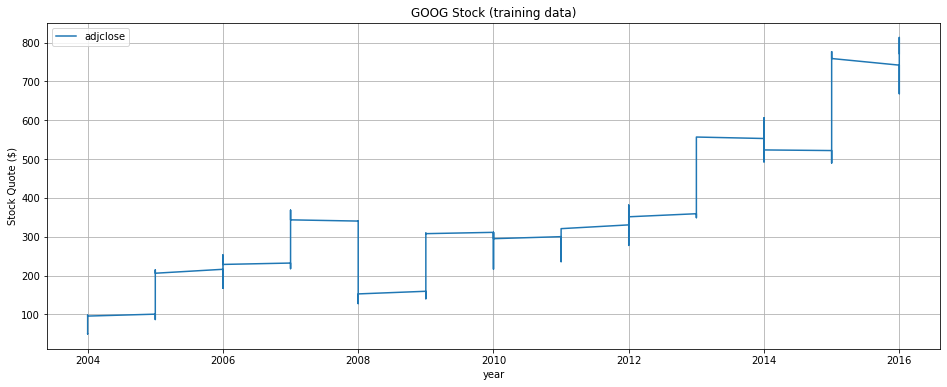

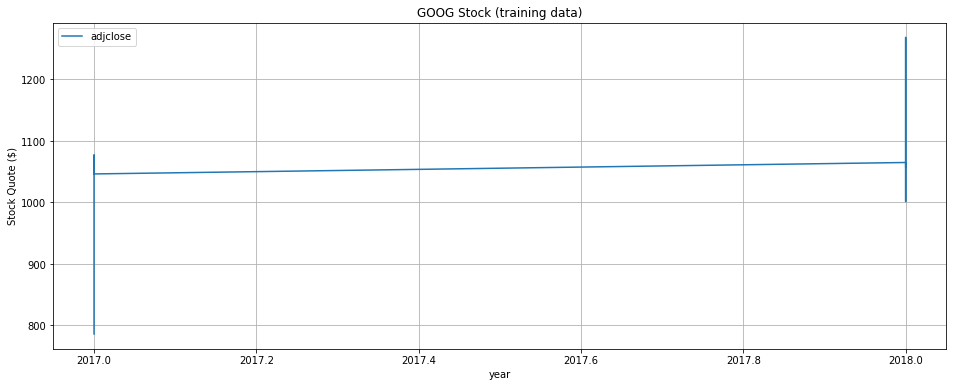

In [16]:
# plot the adjusted close price for training and testing:
trainDF_plot = trainDF.select('year', 'adjclose').toPandas()
trainDF_plot.dtypes
trainDF_plot['year']=trainDF_plot['year'].astype(float)
trainDF_plot['adjclose']=trainDF_plot['adjclose'].astype(float)
trainDF_plot.set_index('year', inplace=True)

testDF_plot = testDF.select('year', 'adjclose').toPandas()
testDF_plot['year']=testDF_plot['year'].astype(float)
testDF_plot['adjclose']=testDF_plot['adjclose'].astype(float)
testDF_plot.set_index('year', inplace=True)
trainDF_plot.plot(figsize=(16, 6), grid=True)
plt.title(company_name + ' Stock (training data)')
plt.ylabel('Stock Quote ($)')
plt.show()
testDF_plot.plot(figsize=(16, 6), grid=True)
plt.title(company_name + ' Stock (training data)')
plt.ylabel('Stock Quote ($)')
plt.show()

In [19]:
#converting datasets into arrays
trainingArray=np.array(trainDF.select('Open','High','Low','Volume','adjclose').collect())
testingArray=np.array(testDF.select('Open','High','Low','Volume','adjclose').collect())
# scale the arrays to keep the values between 0 and 1 to match outcomes found in sigmoid or step functions that are used for activation.
minMaxScale = MinMaxScaler()
minMaxScale.fit(trainingArray)
testingArray = minMaxScale.transform(testingArray)
trainingArray = minMaxScale.transform(trainingArray)

In [20]:
# Split both testingArray and trainingArray  into features, x, and label, y
# The features are composed of the values from Open, High, Low, and Volume. The label is composed of Adj Close. 
xtrain = trainingArray[:, 0:-1]
xtest = testingArray[:, 0:-1]
ytrain = trainingArray[:, -1:]
ytest = testingArray[:, -1:]

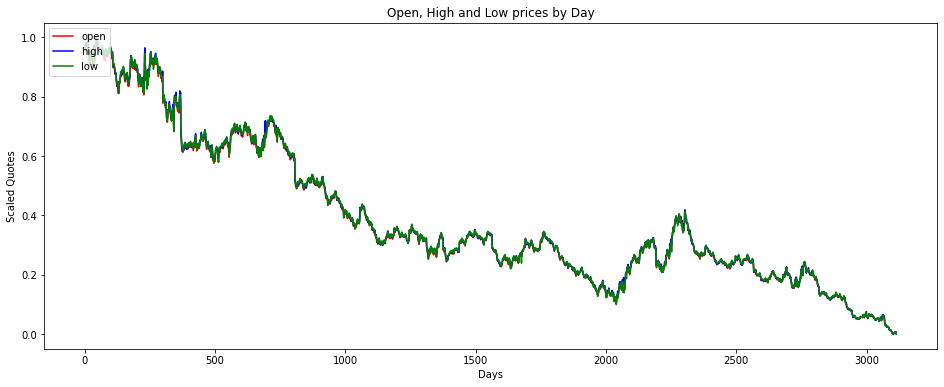

In [21]:
#plot Open, High and Low prices by Day for training dataset
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.legend(loc = 'upper left')
plt.title('Open, High and Low prices by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

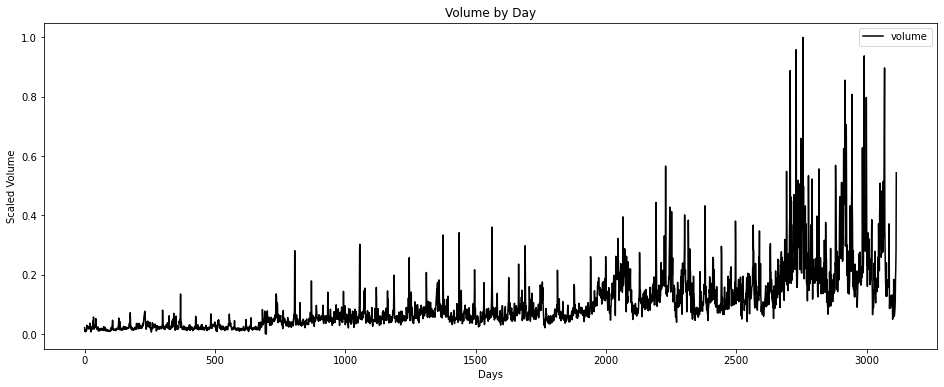

In [22]:
# plot volume by day for training dataset
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,3],color='black', label='volume')
plt.legend(loc = 'upper right')
plt.title('Volume by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Volume')
plt.show()

# **Building the LSTM model**

In [23]:
# Build a Sequential model
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,4)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
# Transform the testing and training data sets into three-dimensional arrays
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [25]:
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

The shape of xtrain is (3115, 1, 4): 
The shape of xtest is (464, 1, 4): 


In [26]:
# train the model
loss = model.fit(xtrain, ytrain, batch_size=10, epochs=100)

Epoch 1/100
312/312 [==============================] - 7s 3ms/step - loss: 0.1108
Epoch 2/100
312/312 [==============================] - 1s 3ms/step - loss: 0.0374
Epoch 3/100
312/312 [==============================] - 1s 3ms/step - loss: 0.0195
Epoch 4/100
312/312 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 5/100
312/312 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 6/100
312/312 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 7/100
312/312 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 8/100
312/312 [==============================] - 1s 3ms/step - loss: 8.9958e-04
Epoch 9/100
312/312 [==============================] - 1s 3ms/step - loss: 8.0071e-04
Epoch 10/100
312/312 [==============================] - 1s 3ms/step - loss: 7.1290e-04
Epoch 11/100
312/312 [==============================] - 1s 3ms/step - loss: 6.4168e-04
Epoch 12/100
312/312 [==============================] - 1s 3ms/step - loss: 5.74

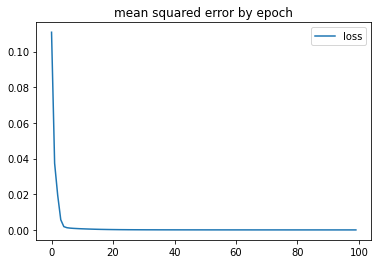

In [27]:
# show the loss in training
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

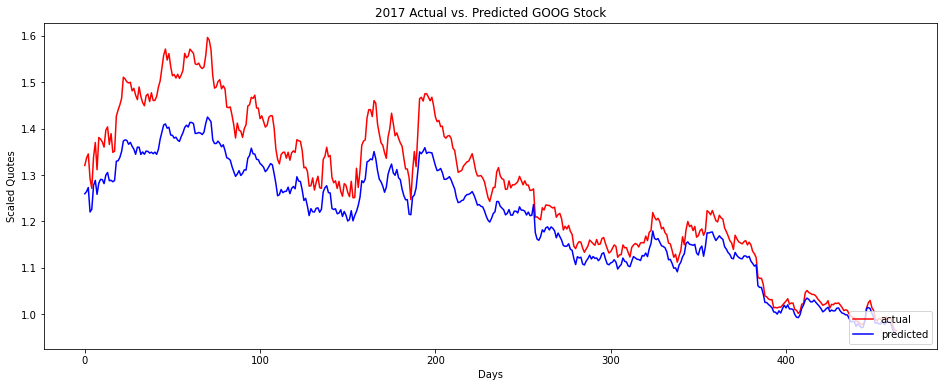

In [28]:
# testing the model
predicted = model.predict(xtest)
# Combine the predicted and ytest arrays into a single unified array
combined_array = np.concatenate((ytest, predicted), axis = 1)
# plot a side by side comparison of Actual versus Predicted stock to compare trends
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('2017 Actual vs. Predicted ' + company_name + ' Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

# **Model Evaluation**

In [29]:
# Calculate the mean squared error between the actual ytest versus predicted stock
np.sqrt(metrics.mean_squared_error(ytest,predicted))


0.07507334332378945